<a href="https://colab.research.google.com/github/manoharreddyvoladri/Quantum_Classification/blob/main/hybrid_version_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kagglehub pennylane tensorflow opencv-python scikit-learn


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_fscore_support
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
import pennylane as qml
from pennylane import numpy as pnp

# For Grad-CAM
import tensorflow.keras.backend as K

In [ ]:

#@title Download and Load Dataset

# Download the dataset via kagglehub
import kagglehub
dataset_path = kagglehub.dataset_download("aminelaatam/weed-classification")
print("Path to dataset files:", dataset_path)

# Assume dataset structure:
# CornWeed/train/corn, CornWeed/train/weed, CornWeed/test/corn, CornWeed/test/weed

def load_images_from_folder(folder, label, img_size=(128, 128)):
    images = []
    labels = []
    for filename in glob(os.path.join(folder, "*")):
        img = cv2.imread(filename)
        if img is not None:
            img = cv2.resize(img, img_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

# Adjust paths based on your dataset folder structure
train_corn_folder = os.path.join(dataset_path, "CornWeed", "train", "corn")
train_weed_folder = os.path.join(dataset_path, "CornWeed", "train", "weed")
test_corn_folder = os.path.join(dataset_path, "CornWeed", "test", "corn")
test_weed_folder = os.path.join(dataset_path, "CornWeed", "test", "weed")

# Label: 0 for corn, 1 for weed
X_train_corn, y_train_corn = load_images_from_folder(train_corn_folder, 0)
X_train_weed, y_train_weed = load_images_from_folder(train_weed_folder, 1)
X_test_corn, y_test_corn = load_images_from_folder(test_corn_folder, 0)
X_test_weed, y_test_weed = load_images_from_folder(test_weed_folder, 1)

# Combine data
X_train = np.concatenate([X_train_corn, X_train_weed], axis=0)
y_train = np.concatenate([y_train_corn, y_train_weed], axis=0)
X_test = np.concatenate([X_test_corn, X_test_weed], axis=0)
y_test = np.concatenate([y_test_corn, y_test_weed], axis=0)

# Normalize pixel values
X_train = X_train.astype('float32')/255.
X_test = X_test.astype('float32')/255.

print("Train samples:", X_train.shape, "Test samples:", X_test.shape)


Path to dataset files: /root/.cache/kagglehub/datasets/aminelaatam/weed-classification/versions/2
Train samples: (1993, 128, 128, 3) Test samples: (809, 128, 128, 3)


In [ ]:
#@title Define CNN Model (Baseline)

def build_cnn_model(input_shape=(128, 128, 3), num_classes=2):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

cnn_model = build_cnn_model()
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

In [ ]:
#@title Training Function and Callbacks

EPOCHS = 10  # set a small number for demo; increase as needed
BATCH_SIZE = 32

# For demonstration, we can use a callback to display training progress
callback = callbacks.EarlyStopping(monitor='val_loss', patience=3)


In [ ]:
# Train CNN model
history_cnn = cnn_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                            validation_split=0.2, callbacks=[callback])


Epoch 1/10
50/50 [==============================] - 77s 1s/step - loss: 0.5501 - accuracy: 0.7811 - val_loss: 1.0956 - val_accuracy: 0.4712
Epoch 2/10
50/50 [==============================] - 64s 1s/step - loss: 0.2835 - accuracy: 0.9034 - val_loss: 0.6596 - val_accuracy: 0.6892
Epoch 3/10
50/50 [==============================] - 66s 1s/step - loss: 0.2928 - accuracy: 0.8971 - val_loss: 1.1746 - val_accuracy: 0.5188
Epoch 4/10
50/50 [==============================] - 65s 1s/step - loss: 0.2476 - accuracy: 0.9065 - val_loss: 0.1451 - val_accuracy: 0.9373
Epoch 5/10
50/50 [==============================] - 65s 1s/step - loss: 0.1840 - accuracy: 0.9335 - val_loss: 0.2030 - val_accuracy: 0.8972
Epoch 6/10
50/50 [==============================] - 63s 1s/step - loss: 0.1799 - accuracy: 0.9348 - val_loss: 0.2983 - val_accuracy: 0.8596
Epoch 7/10
50/50 [==============================] - 64s 1s/step - loss: 0.2002 - accuracy: 0.9260 - val_loss: 0.4350 - val_accuracy: 0.8421


In [ ]:
import pennylane as qml
from pennylane import numpy as np

# Define quantum device
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

# Define a variational quantum circuit
@qml.qnode(dev, interface="tf", diff_method="backprop")
def quantum_circuit(inputs, weights):
    # Ensure inputs are the correct shape
    inputs = qml.math.reshape(inputs, (-1, n_qubits))

    for i in range(n_qubits):
        qml.RY(np.pi * inputs[:, i], wires=i)

    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))

    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Define weight shapes
weight_shapes = {"weights": (1, n_qubits, 3)}

# Create the KerasLayer
qnn_layer = qml.qnn.KerasLayer(quantum_circuit, weight_shapes, output_dim=n_qubits)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_qnn_model(input_shape=(2,), num_classes=2):
    inputs = tf.keras.Input(shape=input_shape)
    x = qnn_layer(inputs)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

qnn_model = build_qnn_model()
qnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
qnn_model.summary()


Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 2)]               0         
                                                                 
 keras_layer_8 (KerasLayer)  (None, 2)                 6         
                                                                 
 dense_15 (Dense)            (None, 2)                 6         
                                                                 
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Example: Reducing input features to 2 dimensions
X_train_reduced = np.mean(X_train, axis=(1, 2))[:, :2]
X_test_reduced = np.mean(X_test, axis=(1, 2))[:, :2]

# Ensure the data is of type float32
X_train_reduced = X_train_reduced.astype('float32')
X_test_reduced = X_test_reduced.astype('float32')


In [ ]:
EPOCHS = 10
BATCH_SIZE = 32

history_qnn = qnn_model.fit(
    X_train_reduced, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2
)


Epoch 1/10


 1/50 [..............................] - ETA: 14s - loss: 0.8127 - accuracy: 0.2812

 2/50 [>.............................] - ETA: 9s - loss: 0.8145 - accuracy: 0.2656 

 3/50 [>.............................] - ETA: 7s - loss: 0.8177 - accuracy: 0.2500

 4/50 [=>............................] - ETA: 7s - loss: 0.8181 - accuracy: 0.2422

 5/50 [==>...........................] - ETA: 6s - loss: 0.8047 - accuracy: 0.2750

 6/50 [==>...........................] - ETA: 6s - loss: 0.8137 - accuracy: 0.2500

 7/50 [===>..........................] - ETA: 6s - loss: 0.8051 - accuracy: 0.2679

 8/50 [===>..........................] - ETA: 6s - loss: 0.8101 - accuracy: 0.2656

 9/50 [====>.........................] - ETA: 6s - loss: 0.8069 - accuracy: 0.2674

10/50 [=====>........................] - ETA: 6s - loss: 0.8059 - accuracy: 0.2656

11/50 [=====>........................] - ETA: 6s - loss: 0.8048 - accuracy: 0.2699

12/50 [======>.......................] - ETA: 6s - loss: 0.8073 - accuracy: 0.2630

13/50 [======>.......................] - ETA: 5s - loss: 0.8047 - accuracy: 0.2644

14/50 [=======>......................] - ETA: 5s - loss: 0.8068 - accuracy: 0.2545

15/50 [========>.....................] - ETA: 5s - loss: 0.8091 - accuracy: 0.2458

16/50 [========>.....................] - ETA: 5s - loss: 0.8072 - accuracy: 0.2559

17/50 [=========>....................] - ETA: 5s - loss: 0.8080 - accuracy: 0.2574

18/50 [=========>....................] - ETA: 4s - loss: 0.8091 - accuracy: 0.2517

19/50 [==========>...................] - ETA: 4s - loss: 0.8073 - accuracy: 0.2566

20/50 [===========>..................] - ETA: 4s - loss: 0.8068 - accuracy: 0.2547

21/50 [===========>..................] - ETA: 4s - loss: 0.8071 - accuracy: 0.2530

22/50 [============>.................] - ETA: 4s - loss: 0.8057 - accuracy: 0.2528

23/50 [============>.................] - ETA: 4s - loss: 0.8079 - accuracy: 0.2500

24/50 [=============>................] - ETA: 4s - loss: 0.8081 - accuracy: 0.2487

25/50 [==============>...............] - ETA: 3s - loss: 0.8048 - accuracy: 0.2562

26/50 [==============>...............] - ETA: 3s - loss: 0.8047 - accuracy: 0.2500

27/50 [===============>..............] - ETA: 3s - loss: 0.8039 - accuracy: 0.2512

28/50 [===============>..............] - ETA: 3s - loss: 0.8039 - accuracy: 0.2500

29/50 [================>.............] - ETA: 3s - loss: 0.8023 - accuracy: 0.2511

30/50 [=================>............] - ETA: 3s - loss: 0.8004 - accuracy: 0.2521

31/50 [=================>............] - ETA: 2s - loss: 0.7997 - accuracy: 0.2540

32/50 [==================>...........] - ETA: 2s - loss: 0.7990 - accuracy: 0.2549

33/50 [==================>...........] - ETA: 2s - loss: 0.7971 - accuracy: 0.2585

34/50 [===================>..........] - ETA: 2s - loss: 0.7969 - accuracy: 0.2592

35/50 [====================>.........] - ETA: 2s - loss: 0.7957 - accuracy: 0.2616

36/50 [====================>.........] - ETA: 2s - loss: 0.7960 - accuracy: 0.2587

37/50 [=====================>........] - ETA: 1s - loss: 0.7952 - accuracy: 0.2601

38/50 [=====================>........] - ETA: 1s - loss: 0.7948 - accuracy: 0.2590

39/50 [======================>.......] - ETA: 1s - loss: 0.7937 - accuracy: 0.2620

40/50 [=======================>......] - ETA: 1s - loss: 0.7932 - accuracy: 0.2633

41/50 [=======================>......] - ETA: 1s - loss: 0.7929 - accuracy: 0.2599

42/50 [========================>.....] - ETA: 1s - loss: 0.7923 - accuracy: 0.2612

43/50 [========================>.....] - ETA: 1s - loss: 0.7918 - accuracy: 0.2602

44/50 [=========================>....] - ETA: 0s - loss: 0.7919 - accuracy: 0.2585

45/50 [==========================>...] - ETA: 0s - loss: 0.7912 - accuracy: 0.2583

46/50 [==========================>...] - ETA: 0s - loss: 0.7904 - accuracy: 0.2595

47/50 [===========================>..] - ETA: 0s - loss: 0.7892 - accuracy: 0.2613

48/50 [===========================>..] - ETA: 0s - loss: 0.7890 - accuracy: 0.2637

49/50 [============================>.] - ETA: 0s - loss: 0.7886 - accuracy: 0.2621

50/50 [==============================] - 8s 167ms/step - loss: 0.7876 - accuracy: 0.2647 - val_loss: 0.6149 - val_accuracy: 0.8747
Epoch 2/10


 1/50 [..............................] - ETA: 6s - loss: 0.7420 - accuracy: 0.4062

 2/50 [>.............................] - ETA: 6s - loss: 0.7377 - accuracy: 0.3906

 3/50 [>.............................] - ETA: 7s - loss: 0.7473 - accuracy: 0.3333

 4/50 [=>............................] - ETA: 8s - loss: 0.7585 - accuracy: 0.2969

 5/50 [==>...........................] - ETA: 8s - loss: 0.7583 - accuracy: 0.2812

 6/50 [==>...........................] - ETA: 8s - loss: 0.7576 - accuracy: 0.2812

 7/50 [===>..........................] - ETA: 8s - loss: 0.7595 - accuracy: 0.2768

 8/50 [===>..........................] - ETA: 7s - loss: 0.7599 - accuracy: 0.2773

 9/50 [====>.........................] - ETA: 7s - loss: 0.7583 - accuracy: 0.2882

10/50 [=====>........................] - ETA: 7s - loss: 0.7570 - accuracy: 0.2844

11/50 [=====>........................] - ETA: 7s - loss: 0.7567 - accuracy: 0.2841

12/50 [======>.......................] - ETA: 7s - loss: 0.7559 - accuracy: 0.2760

13/50 [======>.......................] - ETA: 6s - loss: 0.7553 - accuracy: 0.2788

14/50 [=======>......................] - ETA: 6s - loss: 0.7543 - accuracy: 0.2902

15/50 [========>.....................] - ETA: 6s - loss: 0.7541 - accuracy: 0.2812

16/50 [========>.....................] - ETA: 6s - loss: 0.7556 - accuracy: 0.2773

17/50 [=========>....................] - ETA: 6s - loss: 0.7545 - accuracy: 0.2794

18/50 [=========>....................] - ETA: 6s - loss: 0.7557 - accuracy: 0.2778

19/50 [==========>...................] - ETA: 5s - loss: 0.7558 - accuracy: 0.2730

20/50 [===========>..................] - ETA: 5s - loss: 0.7554 - accuracy: 0.2719

21/50 [===========>..................] - ETA: 5s - loss: 0.7545 - accuracy: 0.2723

22/50 [============>.................] - ETA: 5s - loss: 0.7528 - accuracy: 0.2827

23/50 [============>.................] - ETA: 5s - loss: 0.7520 - accuracy: 0.2853

24/50 [=============>................] - ETA: 4s - loss: 0.7518 - accuracy: 0.2852

25/50 [==============>...............] - ETA: 4s - loss: 0.7504 - accuracy: 0.2887

26/50 [==============>...............] - ETA: 4s - loss: 0.7498 - accuracy: 0.2921

27/50 [===============>..............] - ETA: 4s - loss: 0.7485 - accuracy: 0.2940

28/50 [===============>..............] - ETA: 4s - loss: 0.7483 - accuracy: 0.2935

29/50 [================>.............] - ETA: 3s - loss: 0.7484 - accuracy: 0.2909

30/50 [=================>............] - ETA: 3s - loss: 0.7469 - accuracy: 0.2958

31/50 [=================>............] - ETA: 3s - loss: 0.7456 - accuracy: 0.3024

32/50 [==================>...........] - ETA: 3s - loss: 0.7455 - accuracy: 0.3047

33/50 [==================>...........] - ETA: 3s - loss: 0.7452 - accuracy: 0.3049

34/50 [===================>..........] - ETA: 2s - loss: 0.7448 - accuracy: 0.3088

35/50 [====================>.........] - ETA: 2s - loss: 0.7445 - accuracy: 0.3098

36/50 [====================>.........] - ETA: 2s - loss: 0.7436 - accuracy: 0.3151

37/50 [=====================>........] - ETA: 2s - loss: 0.7431 - accuracy: 0.3201

38/50 [=====================>........] - ETA: 2s - loss: 0.7417 - accuracy: 0.3248

39/50 [======================>.......] - ETA: 1s - loss: 0.7420 - accuracy: 0.3261

40/50 [=======================>......] - ETA: 1s - loss: 0.7417 - accuracy: 0.3273

41/50 [=======================>......] - ETA: 1s - loss: 0.7411 - accuracy: 0.3293

42/50 [========================>.....] - ETA: 1s - loss: 0.7411 - accuracy: 0.3266

43/50 [========================>.....] - ETA: 1s - loss: 0.7406 - accuracy: 0.3270

44/50 [=========================>....] - ETA: 1s - loss: 0.7398 - accuracy: 0.3317

45/50 [==========================>...] - ETA: 0s - loss: 0.7392 - accuracy: 0.3347

46/50 [==========================>...] - ETA: 0s - loss: 0.7389 - accuracy: 0.3356

47/50 [===========================>..] - ETA: 0s - loss: 0.7391 - accuracy: 0.3338

48/50 [===========================>..] - ETA: 0s - loss: 0.7388 - accuracy: 0.3346

49/50 [============================>.] - ETA: 0s - loss: 0.7380 - accuracy: 0.3380

50/50 [==============================] - 9s 190ms/step - loss: 0.7379 - accuracy: 0.3388 - val_loss: 0.6929 - val_accuracy: 0.5038
Epoch 3/10


 1/50 [..............................] - ETA: 7s - loss: 0.7190 - accuracy: 0.4688

 2/50 [>.............................] - ETA: 6s - loss: 0.7117 - accuracy: 0.5000

 3/50 [>.............................] - ETA: 6s - loss: 0.7140 - accuracy: 0.5000

 4/50 [=>............................] - ETA: 6s - loss: 0.7146 - accuracy: 0.5078

 5/50 [==>...........................] - ETA: 6s - loss: 0.7128 - accuracy: 0.5000

 6/50 [==>...........................] - ETA: 6s - loss: 0.7148 - accuracy: 0.4948

 7/50 [===>..........................] - ETA: 6s - loss: 0.7128 - accuracy: 0.5045

 8/50 [===>..........................] - ETA: 6s - loss: 0.7152 - accuracy: 0.4922

 9/50 [====>.........................] - ETA: 6s - loss: 0.7170 - accuracy: 0.4826

10/50 [=====>........................] - ETA: 6s - loss: 0.7155 - accuracy: 0.4844

11/50 [=====>........................] - ETA: 6s - loss: 0.7134 - accuracy: 0.4943

12/50 [======>.......................] - ETA: 5s - loss: 0.7131 - accuracy: 0.4922

13/50 [======>.......................] - ETA: 5s - loss: 0.7119 - accuracy: 0.4928

14/50 [=======>......................] - ETA: 5s - loss: 0.7115 - accuracy: 0.4933

15/50 [========>.....................] - ETA: 5s - loss: 0.7113 - accuracy: 0.4958

16/50 [========>.....................] - ETA: 5s - loss: 0.7126 - accuracy: 0.4844

17/50 [=========>....................] - ETA: 5s - loss: 0.7118 - accuracy: 0.4871

18/50 [=========>....................] - ETA: 5s - loss: 0.7117 - accuracy: 0.4844

19/50 [==========>...................] - ETA: 4s - loss: 0.7113 - accuracy: 0.4803

20/50 [===========>..................] - ETA: 4s - loss: 0.7118 - accuracy: 0.4766

21/50 [===========>..................] - ETA: 4s - loss: 0.7112 - accuracy: 0.4747

22/50 [============>.................] - ETA: 4s - loss: 0.7105 - accuracy: 0.4773

23/50 [============>.................] - ETA: 4s - loss: 0.7106 - accuracy: 0.4728

24/50 [=============>................] - ETA: 4s - loss: 0.7108 - accuracy: 0.4714

25/50 [==============>...............] - ETA: 3s - loss: 0.7103 - accuracy: 0.4712

26/50 [==============>...............] - ETA: 3s - loss: 0.7102 - accuracy: 0.4700

27/50 [===============>..............] - ETA: 3s - loss: 0.7092 - accuracy: 0.4745

28/50 [===============>..............] - ETA: 3s - loss: 0.7090 - accuracy: 0.4732

29/50 [================>.............] - ETA: 3s - loss: 0.7083 - accuracy: 0.4731

30/50 [=================>............] - ETA: 3s - loss: 0.7078 - accuracy: 0.4792

31/50 [=================>............] - ETA: 3s - loss: 0.7073 - accuracy: 0.4808

32/50 [==================>...........] - ETA: 2s - loss: 0.7072 - accuracy: 0.4785

33/50 [==================>...........] - ETA: 2s - loss: 0.7076 - accuracy: 0.4763

34/50 [===================>..........] - ETA: 2s - loss: 0.7070 - accuracy: 0.4789

35/50 [====================>.........] - ETA: 2s - loss: 0.7070 - accuracy: 0.4786

36/50 [====================>.........] - ETA: 2s - loss: 0.7064 - accuracy: 0.4818

37/50 [=====================>........] - ETA: 2s - loss: 0.7061 - accuracy: 0.4840

38/50 [=====================>........] - ETA: 2s - loss: 0.7055 - accuracy: 0.4860

39/50 [======================>.......] - ETA: 1s - loss: 0.7056 - accuracy: 0.4864

40/50 [=======================>......] - ETA: 1s - loss: 0.7046 - accuracy: 0.4891

41/50 [=======================>......] - ETA: 1s - loss: 0.7047 - accuracy: 0.4878

42/50 [========================>.....] - ETA: 1s - loss: 0.7044 - accuracy: 0.4866

43/50 [========================>.....] - ETA: 1s - loss: 0.7045 - accuracy: 0.4862

44/50 [=========================>....] - ETA: 1s - loss: 0.7037 - accuracy: 0.4886

45/50 [==========================>...] - ETA: 0s - loss: 0.7031 - accuracy: 0.4903

46/50 [==========================>...] - ETA: 0s - loss: 0.7031 - accuracy: 0.4878

47/50 [===========================>..] - ETA: 0s - loss: 0.7025 - accuracy: 0.4914

48/50 [===========================>..] - ETA: 0s - loss: 0.7020 - accuracy: 0.4928

49/50 [============================>.] - ETA: 0s - loss: 0.7017 - accuracy: 0.4930

50/50 [==============================] - 10s 196ms/step - loss: 0.7013 - accuracy: 0.4944 - val_loss: 0.7635 - val_accuracy: 0.0902
Epoch 4/10


 1/50 [..............................] - ETA: 6s - loss: 0.6700 - accuracy: 0.6562

 2/50 [>.............................] - ETA: 7s - loss: 0.6700 - accuracy: 0.6562

 3/50 [>.............................] - ETA: 7s - loss: 0.6804 - accuracy: 0.5833

 4/50 [=>............................] - ETA: 7s - loss: 0.6853 - accuracy: 0.5625

 5/50 [==>...........................] - ETA: 7s - loss: 0.6866 - accuracy: 0.5688

 6/50 [==>...........................] - ETA: 6s - loss: 0.6861 - accuracy: 0.5677

 7/50 [===>..........................] - ETA: 6s - loss: 0.6833 - accuracy: 0.5759

 8/50 [===>..........................] - ETA: 6s - loss: 0.6847 - accuracy: 0.5586

 9/50 [====>.........................] - ETA: 6s - loss: 0.6864 - accuracy: 0.5417

10/50 [=====>........................] - ETA: 6s - loss: 0.6882 - accuracy: 0.5250

11/50 [=====>........................] - ETA: 6s - loss: 0.6854 - accuracy: 0.5426

12/50 [======>.......................] - ETA: 6s - loss: 0.6847 - accuracy: 0.5469

13/50 [======>.......................] - ETA: 6s - loss: 0.6838 - accuracy: 0.5481

14/50 [=======>......................] - ETA: 5s - loss: 0.6822 - accuracy: 0.5536

15/50 [========>.....................] - ETA: 5s - loss: 0.6813 - accuracy: 0.5604

16/50 [========>.....................] - ETA: 5s - loss: 0.6812 - accuracy: 0.5547

17/50 [=========>....................] - ETA: 5s - loss: 0.6809 - accuracy: 0.5588

18/50 [=========>....................] - ETA: 5s - loss: 0.6801 - accuracy: 0.5625

19/50 [==========>...................] - ETA: 4s - loss: 0.6801 - accuracy: 0.5625

20/50 [===========>..................] - ETA: 4s - loss: 0.6807 - accuracy: 0.5594

21/50 [===========>..................] - ETA: 4s - loss: 0.6796 - accuracy: 0.5625

22/50 [============>.................] - ETA: 4s - loss: 0.6795 - accuracy: 0.5639

23/50 [============>.................] - ETA: 4s - loss: 0.6789 - accuracy: 0.5666

24/50 [=============>................] - ETA: 4s - loss: 0.6796 - accuracy: 0.5638

25/50 [==============>...............] - ETA: 4s - loss: 0.6797 - accuracy: 0.5650

26/50 [==============>...............] - ETA: 3s - loss: 0.6794 - accuracy: 0.5661

27/50 [===============>..............] - ETA: 3s - loss: 0.6794 - accuracy: 0.5648

28/50 [===============>..............] - ETA: 3s - loss: 0.6786 - accuracy: 0.5658

29/50 [================>.............] - ETA: 3s - loss: 0.6772 - accuracy: 0.5711

30/50 [=================>............] - ETA: 3s - loss: 0.6772 - accuracy: 0.5698

31/50 [=================>............] - ETA: 3s - loss: 0.6774 - accuracy: 0.5696

32/50 [==================>...........] - ETA: 2s - loss: 0.6773 - accuracy: 0.5713

33/50 [==================>...........] - ETA: 2s - loss: 0.6777 - accuracy: 0.5691

34/50 [===================>..........] - ETA: 2s - loss: 0.6780 - accuracy: 0.5689

35/50 [====================>.........] - ETA: 2s - loss: 0.6780 - accuracy: 0.5705

36/50 [====================>.........] - ETA: 2s - loss: 0.6779 - accuracy: 0.5720

37/50 [=====================>........] - ETA: 2s - loss: 0.6767 - accuracy: 0.5760

38/50 [=====================>........] - ETA: 1s - loss: 0.6774 - accuracy: 0.5732

39/50 [======================>.......] - ETA: 1s - loss: 0.6769 - accuracy: 0.5729

40/50 [=======================>......] - ETA: 1s - loss: 0.6768 - accuracy: 0.5727

41/50 [=======================>......] - ETA: 1s - loss: 0.6761 - accuracy: 0.5739

42/50 [========================>.....] - ETA: 1s - loss: 0.6756 - accuracy: 0.5759

43/50 [========================>.....] - ETA: 1s - loss: 0.6758 - accuracy: 0.5749

44/50 [=========================>....] - ETA: 0s - loss: 0.6755 - accuracy: 0.5774

45/50 [==========================>...] - ETA: 0s - loss: 0.6755 - accuracy: 0.5778

46/50 [==========================>...] - ETA: 0s - loss: 0.6746 - accuracy: 0.5808

47/50 [===========================>..] - ETA: 0s - loss: 0.6742 - accuracy: 0.5838

48/50 [===========================>..] - ETA: 0s - loss: 0.6743 - accuracy: 0.5820

49/50 [============================>.] - ETA: 0s - loss: 0.6742 - accuracy: 0.5835

50/50 [==============================] - 9s 181ms/step - loss: 0.6737 - accuracy: 0.5872 - val_loss: 0.8266 - val_accuracy: 0.0125
Epoch 5/10


 1/50 [..............................] - ETA: 7s - loss: 0.6449 - accuracy: 0.7500

 2/50 [>.............................] - ETA: 8s - loss: 0.6531 - accuracy: 0.7188

 3/50 [>.............................] - ETA: 8s - loss: 0.6478 - accuracy: 0.7292

 4/50 [=>............................] - ETA: 8s - loss: 0.6593 - accuracy: 0.6719

 5/50 [==>...........................] - ETA: 9s - loss: 0.6555 - accuracy: 0.6938

 6/50 [==>...........................] - ETA: 8s - loss: 0.6551 - accuracy: 0.6875

 7/50 [===>..........................] - ETA: 9s - loss: 0.6561 - accuracy: 0.6920

 8/50 [===>..........................] - ETA: 8s - loss: 0.6562 - accuracy: 0.6914

 9/50 [====>.........................] - ETA: 8s - loss: 0.6562 - accuracy: 0.6875

10/50 [=====>........................] - ETA: 8s - loss: 0.6551 - accuracy: 0.6969

11/50 [=====>........................] - ETA: 8s - loss: 0.6577 - accuracy: 0.6847

12/50 [======>.......................] - ETA: 8s - loss: 0.6554 - accuracy: 0.6901

13/50 [======>.......................] - ETA: 7s - loss: 0.6589 - accuracy: 0.6803

14/50 [=======>......................] - ETA: 7s - loss: 0.6576 - accuracy: 0.6875

15/50 [========>.....................] - ETA: 7s - loss: 0.6568 - accuracy: 0.6938

16/50 [========>.....................] - ETA: 7s - loss: 0.6589 - accuracy: 0.6895

17/50 [=========>....................] - ETA: 7s - loss: 0.6592 - accuracy: 0.6893

18/50 [=========>....................] - ETA: 7s - loss: 0.6604 - accuracy: 0.6858

19/50 [==========>...................] - ETA: 6s - loss: 0.6608 - accuracy: 0.6842

20/50 [===========>..................] - ETA: 6s - loss: 0.6606 - accuracy: 0.6844

21/50 [===========>..................] - ETA: 6s - loss: 0.6599 - accuracy: 0.6875

22/50 [============>.................] - ETA: 6s - loss: 0.6598 - accuracy: 0.6889

23/50 [============>.................] - ETA: 6s - loss: 0.6589 - accuracy: 0.6943

24/50 [=============>................] - ETA: 5s - loss: 0.6592 - accuracy: 0.6940

25/50 [==============>...............] - ETA: 5s - loss: 0.6605 - accuracy: 0.6900

26/50 [==============>...............] - ETA: 5s - loss: 0.6606 - accuracy: 0.6899

27/50 [===============>..............] - ETA: 4s - loss: 0.6596 - accuracy: 0.6933

28/50 [===============>..............] - ETA: 4s - loss: 0.6596 - accuracy: 0.6942

29/50 [================>.............] - ETA: 4s - loss: 0.6596 - accuracy: 0.6940

30/50 [=================>............] - ETA: 4s - loss: 0.6578 - accuracy: 0.6990

31/50 [=================>............] - ETA: 4s - loss: 0.6562 - accuracy: 0.7006

32/50 [==================>...........] - ETA: 3s - loss: 0.6570 - accuracy: 0.6992

33/50 [==================>...........] - ETA: 3s - loss: 0.6566 - accuracy: 0.7017

34/50 [===================>..........] - ETA: 3s - loss: 0.6570 - accuracy: 0.7022

35/50 [====================>.........] - ETA: 3s - loss: 0.6569 - accuracy: 0.7027

36/50 [====================>.........] - ETA: 2s - loss: 0.6567 - accuracy: 0.7023

37/50 [=====================>........] - ETA: 2s - loss: 0.6567 - accuracy: 0.7019

38/50 [=====================>........] - ETA: 2s - loss: 0.6566 - accuracy: 0.7023

39/50 [======================>.......] - ETA: 2s - loss: 0.6564 - accuracy: 0.7043

40/50 [=======================>......] - ETA: 2s - loss: 0.6561 - accuracy: 0.7055

41/50 [=======================>......] - ETA: 1s - loss: 0.6560 - accuracy: 0.7066

42/50 [========================>.....] - ETA: 1s - loss: 0.6566 - accuracy: 0.7061

43/50 [========================>.....] - ETA: 1s - loss: 0.6563 - accuracy: 0.7064

44/50 [=========================>....] - ETA: 1s - loss: 0.6559 - accuracy: 0.7088

45/50 [==========================>...] - ETA: 1s - loss: 0.6554 - accuracy: 0.7097

46/50 [==========================>...] - ETA: 0s - loss: 0.6553 - accuracy: 0.7106

47/50 [===========================>..] - ETA: 0s - loss: 0.6535 - accuracy: 0.7154

48/50 [===========================>..] - ETA: 0s - loss: 0.6529 - accuracy: 0.7174

49/50 [============================>.] - ETA: 0s - loss: 0.6523 - accuracy: 0.7194

50/50 [==============================] - 11s 213ms/step - loss: 0.6524 - accuracy: 0.7196 - val_loss: 0.8827 - val_accuracy: 0.0000e+00
Epoch 6/10


 1/50 [..............................] - ETA: 7s - loss: 0.6214 - accuracy: 0.8750

 2/50 [>.............................] - ETA: 9s - loss: 0.6360 - accuracy: 0.8125

 3/50 [>.............................] - ETA: 8s - loss: 0.6422 - accuracy: 0.7812

 4/50 [=>............................] - ETA: 8s - loss: 0.6445 - accuracy: 0.7734

 5/50 [==>...........................] - ETA: 8s - loss: 0.6412 - accuracy: 0.7688

 6/50 [==>...........................] - ETA: 7s - loss: 0.6499 - accuracy: 0.7396

 7/50 [===>..........................] - ETA: 7s - loss: 0.6523 - accuracy: 0.7277

 8/50 [===>..........................] - ETA: 7s - loss: 0.6508 - accuracy: 0.7305

 9/50 [====>.........................] - ETA: 7s - loss: 0.6485 - accuracy: 0.7326

10/50 [=====>........................] - ETA: 7s - loss: 0.6508 - accuracy: 0.7250

11/50 [=====>........................] - ETA: 6s - loss: 0.6463 - accuracy: 0.7358

12/50 [======>.......................] - ETA: 6s - loss: 0.6443 - accuracy: 0.7422

13/50 [======>.......................] - ETA: 6s - loss: 0.6440 - accuracy: 0.7404

14/50 [=======>......................] - ETA: 6s - loss: 0.6421 - accuracy: 0.7478

15/50 [========>.....................] - ETA: 6s - loss: 0.6454 - accuracy: 0.7396

16/50 [========>.....................] - ETA: 6s - loss: 0.6451 - accuracy: 0.7441

17/50 [=========>....................] - ETA: 5s - loss: 0.6445 - accuracy: 0.7445

18/50 [=========>....................] - ETA: 5s - loss: 0.6449 - accuracy: 0.7448

19/50 [==========>...................] - ETA: 5s - loss: 0.6446 - accuracy: 0.7451

20/50 [===========>..................] - ETA: 5s - loss: 0.6476 - accuracy: 0.7391

21/50 [===========>..................] - ETA: 5s - loss: 0.6465 - accuracy: 0.7396

22/50 [============>.................] - ETA: 5s - loss: 0.6463 - accuracy: 0.7415

23/50 [============>.................] - ETA: 4s - loss: 0.6462 - accuracy: 0.7418

24/50 [=============>................] - ETA: 4s - loss: 0.6465 - accuracy: 0.7422

25/50 [==============>...............] - ETA: 4s - loss: 0.6470 - accuracy: 0.7387

26/50 [==============>...............] - ETA: 4s - loss: 0.6458 - accuracy: 0.7416

27/50 [===============>..............] - ETA: 4s - loss: 0.6444 - accuracy: 0.7442

28/50 [===============>..............] - ETA: 4s - loss: 0.6433 - accuracy: 0.7478

29/50 [================>.............] - ETA: 4s - loss: 0.6433 - accuracy: 0.7478

30/50 [=================>............] - ETA: 3s - loss: 0.6432 - accuracy: 0.7479

31/50 [=================>............] - ETA: 3s - loss: 0.6419 - accuracy: 0.7500

32/50 [==================>...........] - ETA: 3s - loss: 0.6409 - accuracy: 0.7520

33/50 [==================>...........] - ETA: 3s - loss: 0.6402 - accuracy: 0.7547

34/50 [===================>..........] - ETA: 3s - loss: 0.6411 - accuracy: 0.7518

35/50 [====================>.........] - ETA: 3s - loss: 0.6433 - accuracy: 0.7455

36/50 [====================>.........] - ETA: 2s - loss: 0.6445 - accuracy: 0.7422

37/50 [=====================>........] - ETA: 2s - loss: 0.6436 - accuracy: 0.7432

38/50 [=====================>........] - ETA: 2s - loss: 0.6417 - accuracy: 0.7475

39/50 [======================>.......] - ETA: 2s - loss: 0.6423 - accuracy: 0.7452

40/50 [=======================>......] - ETA: 2s - loss: 0.6409 - accuracy: 0.7477

41/50 [=======================>......] - ETA: 1s - loss: 0.6409 - accuracy: 0.7470

42/50 [========================>.....] - ETA: 1s - loss: 0.6400 - accuracy: 0.7478

43/50 [========================>.....] - ETA: 1s - loss: 0.6393 - accuracy: 0.7485

44/50 [=========================>....] - ETA: 1s - loss: 0.6397 - accuracy: 0.7464

45/50 [==========================>...] - ETA: 1s - loss: 0.6397 - accuracy: 0.7458

46/50 [==========================>...] - ETA: 0s - loss: 0.6392 - accuracy: 0.7466

47/50 [===========================>..] - ETA: 0s - loss: 0.6389 - accuracy: 0.7473

48/50 [===========================>..] - ETA: 0s - loss: 0.6378 - accuracy: 0.7493

49/50 [============================>.] - ETA: 0s - loss: 0.6363 - accuracy: 0.7513

50/50 [==============================] - 12s 232ms/step - loss: 0.6355 - accuracy: 0.7528 - val_loss: 0.9318 - val_accuracy: 0.0000e+00
Epoch 7/10


 1/50 [..............................] - ETA: 7s - loss: 0.5841 - accuracy: 0.8438

 2/50 [>.............................] - ETA: 9s - loss: 0.6038 - accuracy: 0.7969

 3/50 [>.............................] - ETA: 9s - loss: 0.6075 - accuracy: 0.7917

 4/50 [=>............................] - ETA: 8s - loss: 0.6059 - accuracy: 0.7969

 5/50 [==>...........................] - ETA: 8s - loss: 0.6116 - accuracy: 0.7812

 6/50 [==>...........................] - ETA: 7s - loss: 0.6130 - accuracy: 0.7760

 7/50 [===>..........................] - ETA: 7s - loss: 0.6157 - accuracy: 0.7723

 8/50 [===>..........................] - ETA: 7s - loss: 0.6125 - accuracy: 0.7812

 9/50 [====>.........................] - ETA: 7s - loss: 0.6157 - accuracy: 0.7778

10/50 [=====>........................] - ETA: 7s - loss: 0.6180 - accuracy: 0.7719

11/50 [=====>........................] - ETA: 7s - loss: 0.6202 - accuracy: 0.7670

12/50 [======>.......................] - ETA: 6s - loss: 0.6216 - accuracy: 0.7630

13/50 [======>.......................] - ETA: 6s - loss: 0.6230 - accuracy: 0.7572

14/50 [=======>......................] - ETA: 6s - loss: 0.6226 - accuracy: 0.7589

15/50 [========>.....................] - ETA: 6s - loss: 0.6224 - accuracy: 0.7604

16/50 [========>.....................] - ETA: 6s - loss: 0.6242 - accuracy: 0.7578

17/50 [=========>....................] - ETA: 6s - loss: 0.6241 - accuracy: 0.7592

18/50 [=========>....................] - ETA: 5s - loss: 0.6259 - accuracy: 0.7552

19/50 [==========>...................] - ETA: 5s - loss: 0.6260 - accuracy: 0.7549

20/50 [===========>..................] - ETA: 5s - loss: 0.6265 - accuracy: 0.7547

21/50 [===========>..................] - ETA: 5s - loss: 0.6245 - accuracy: 0.7589

22/50 [============>.................] - ETA: 5s - loss: 0.6244 - accuracy: 0.7585

23/50 [============>.................] - ETA: 5s - loss: 0.6236 - accuracy: 0.7595

24/50 [=============>................] - ETA: 4s - loss: 0.6226 - accuracy: 0.7617

25/50 [==============>...............] - ETA: 4s - loss: 0.6213 - accuracy: 0.7638

26/50 [==============>...............] - ETA: 4s - loss: 0.6234 - accuracy: 0.7584

27/50 [===============>..............] - ETA: 4s - loss: 0.6214 - accuracy: 0.7616

28/50 [===============>..............] - ETA: 4s - loss: 0.6206 - accuracy: 0.7634

29/50 [================>.............] - ETA: 3s - loss: 0.6214 - accuracy: 0.7619

30/50 [=================>............] - ETA: 3s - loss: 0.6213 - accuracy: 0.7615

31/50 [=================>............] - ETA: 3s - loss: 0.6210 - accuracy: 0.7621

32/50 [==================>...........] - ETA: 3s - loss: 0.6198 - accuracy: 0.7646

33/50 [==================>...........] - ETA: 3s - loss: 0.6206 - accuracy: 0.7633

34/50 [===================>..........] - ETA: 2s - loss: 0.6197 - accuracy: 0.7647

35/50 [====================>.........] - ETA: 2s - loss: 0.6225 - accuracy: 0.7580

36/50 [====================>.........] - ETA: 2s - loss: 0.6239 - accuracy: 0.7535

37/50 [=====================>........] - ETA: 2s - loss: 0.6235 - accuracy: 0.7534

38/50 [=====================>........] - ETA: 2s - loss: 0.6238 - accuracy: 0.7525

39/50 [======================>.......] - ETA: 2s - loss: 0.6231 - accuracy: 0.7540

40/50 [=======================>......] - ETA: 1s - loss: 0.6249 - accuracy: 0.7492

41/50 [=======================>......] - ETA: 1s - loss: 0.6243 - accuracy: 0.7500

42/50 [========================>.....] - ETA: 1s - loss: 0.6228 - accuracy: 0.7522

43/50 [========================>.....] - ETA: 1s - loss: 0.6236 - accuracy: 0.7507

44/50 [=========================>....] - ETA: 1s - loss: 0.6238 - accuracy: 0.7500

45/50 [==========================>...] - ETA: 0s - loss: 0.6228 - accuracy: 0.7514

46/50 [==========================>...] - ETA: 0s - loss: 0.6223 - accuracy: 0.7527

47/50 [===========================>..] - ETA: 0s - loss: 0.6228 - accuracy: 0.7513

48/50 [===========================>..] - ETA: 0s - loss: 0.6219 - accuracy: 0.7526

49/50 [============================>.] - ETA: 0s - loss: 0.6223 - accuracy: 0.7519

50/50 [==============================] - 11s 219ms/step - loss: 0.6218 - accuracy: 0.7528 - val_loss: 0.9791 - val_accuracy: 0.0000e+00
Epoch 8/10


 1/50 [..............................] - ETA: 10s - loss: 0.6428 - accuracy: 0.6875

 2/50 [>.............................] - ETA: 11s - loss: 0.6134 - accuracy: 0.7500

 3/50 [>.............................] - ETA: 10s - loss: 0.6132 - accuracy: 0.7500

 4/50 [=>............................] - ETA: 10s - loss: 0.6067 - accuracy: 0.7578

 5/50 [==>...........................] - ETA: 9s - loss: 0.6095 - accuracy: 0.7563 

 6/50 [==>...........................] - ETA: 8s - loss: 0.6118 - accuracy: 0.7552

 7/50 [===>..........................] - ETA: 8s - loss: 0.6151 - accuracy: 0.7500

 8/50 [===>..........................] - ETA: 8s - loss: 0.6241 - accuracy: 0.7344

 9/50 [====>.........................] - ETA: 8s - loss: 0.6303 - accuracy: 0.7222

10/50 [=====>........................] - ETA: 7s - loss: 0.6229 - accuracy: 0.7375

11/50 [=====>........................] - ETA: 7s - loss: 0.6284 - accuracy: 0.7273

12/50 [======>.......................] - ETA: 7s - loss: 0.6207 - accuracy: 0.7422

13/50 [======>.......................] - ETA: 7s - loss: 0.6263 - accuracy: 0.7308

14/50 [=======>......................] - ETA: 7s - loss: 0.6183 - accuracy: 0.7455

15/50 [========>.....................] - ETA: 6s - loss: 0.6194 - accuracy: 0.7437

16/50 [========>.....................] - ETA: 6s - loss: 0.6201 - accuracy: 0.7422

17/50 [=========>....................] - ETA: 6s - loss: 0.6193 - accuracy: 0.7445

18/50 [=========>....................] - ETA: 6s - loss: 0.6147 - accuracy: 0.7535

19/50 [==========>...................] - ETA: 6s - loss: 0.6152 - accuracy: 0.7533

20/50 [===========>..................] - ETA: 5s - loss: 0.6134 - accuracy: 0.7563

21/50 [===========>..................] - ETA: 5s - loss: 0.6147 - accuracy: 0.7530

22/50 [============>.................] - ETA: 5s - loss: 0.6146 - accuracy: 0.7528

23/50 [============>.................] - ETA: 5s - loss: 0.6138 - accuracy: 0.7541

24/50 [=============>................] - ETA: 5s - loss: 0.6122 - accuracy: 0.7578

25/50 [==============>...............] - ETA: 4s - loss: 0.6139 - accuracy: 0.7550

26/50 [==============>...............] - ETA: 4s - loss: 0.6151 - accuracy: 0.7524

27/50 [===============>..............] - ETA: 4s - loss: 0.6160 - accuracy: 0.7500

28/50 [===============>..............] - ETA: 4s - loss: 0.6171 - accuracy: 0.7478

29/50 [================>.............] - ETA: 4s - loss: 0.6170 - accuracy: 0.7478

30/50 [=================>............] - ETA: 3s - loss: 0.6142 - accuracy: 0.7531

31/50 [=================>............] - ETA: 3s - loss: 0.6182 - accuracy: 0.7450

32/50 [==================>...........] - ETA: 3s - loss: 0.6189 - accuracy: 0.7432

33/50 [==================>...........] - ETA: 3s - loss: 0.6188 - accuracy: 0.7434

34/50 [===================>..........] - ETA: 3s - loss: 0.6195 - accuracy: 0.7417

35/50 [====================>.........] - ETA: 2s - loss: 0.6198 - accuracy: 0.7411

36/50 [====================>.........] - ETA: 2s - loss: 0.6194 - accuracy: 0.7413

37/50 [=====================>........] - ETA: 2s - loss: 0.6215 - accuracy: 0.7373

38/50 [=====================>........] - ETA: 2s - loss: 0.6212 - accuracy: 0.7377

39/50 [======================>.......] - ETA: 2s - loss: 0.6212 - accuracy: 0.7372

40/50 [=======================>......] - ETA: 1s - loss: 0.6187 - accuracy: 0.7414

41/50 [=======================>......] - ETA: 1s - loss: 0.6191 - accuracy: 0.7401

42/50 [========================>.....] - ETA: 1s - loss: 0.6180 - accuracy: 0.7411

43/50 [========================>.....] - ETA: 1s - loss: 0.6161 - accuracy: 0.7442

44/50 [=========================>....] - ETA: 1s - loss: 0.6147 - accuracy: 0.7464

45/50 [==========================>...] - ETA: 0s - loss: 0.6122 - accuracy: 0.7507

46/50 [==========================>...] - ETA: 0s - loss: 0.6118 - accuracy: 0.7514

47/50 [===========================>..] - ETA: 0s - loss: 0.6112 - accuracy: 0.7527

48/50 [===========================>..] - ETA: 0s - loss: 0.6107 - accuracy: 0.7533

49/50 [============================>.] - ETA: 0s - loss: 0.6110 - accuracy: 0.7526

50/50 [==============================] - 10s 204ms/step - loss: 0.6106 - accuracy: 0.7528 - val_loss: 1.0179 - val_accuracy: 0.0000e+00
Epoch 9/10


 1/50 [..............................] - ETA: 8s - loss: 0.5324 - accuracy: 0.8750

 2/50 [>.............................] - ETA: 8s - loss: 0.5373 - accuracy: 0.8750

 3/50 [>.............................] - ETA: 8s - loss: 0.5672 - accuracy: 0.8229

 4/50 [=>............................] - ETA: 8s - loss: 0.5598 - accuracy: 0.8359

 5/50 [==>...........................] - ETA: 8s - loss: 0.5674 - accuracy: 0.8188

 6/50 [==>...........................] - ETA: 8s - loss: 0.5709 - accuracy: 0.8125

 7/50 [===>..........................] - ETA: 8s - loss: 0.5805 - accuracy: 0.7946

 8/50 [===>..........................] - ETA: 8s - loss: 0.5837 - accuracy: 0.7891

 9/50 [====>.........................] - ETA: 8s - loss: 0.5801 - accuracy: 0.7951

10/50 [=====>........................] - ETA: 8s - loss: 0.5850 - accuracy: 0.7875

11/50 [=====>........................] - ETA: 7s - loss: 0.5955 - accuracy: 0.7699

12/50 [======>.......................] - ETA: 7s - loss: 0.5949 - accuracy: 0.7708

13/50 [======>.......................] - ETA: 7s - loss: 0.5939 - accuracy: 0.7716

14/50 [=======>......................] - ETA: 7s - loss: 0.5956 - accuracy: 0.7701

15/50 [========>.....................] - ETA: 6s - loss: 0.5964 - accuracy: 0.7688

16/50 [========>.....................] - ETA: 6s - loss: 0.5977 - accuracy: 0.7656

17/50 [=========>....................] - ETA: 6s - loss: 0.5977 - accuracy: 0.7665

18/50 [=========>....................] - ETA: 6s - loss: 0.5988 - accuracy: 0.7639

19/50 [==========>...................] - ETA: 6s - loss: 0.5968 - accuracy: 0.7664

20/50 [===========>..................] - ETA: 6s - loss: 0.6012 - accuracy: 0.7578

21/50 [===========>..................] - ETA: 6s - loss: 0.6025 - accuracy: 0.7560

22/50 [============>.................] - ETA: 5s - loss: 0.6015 - accuracy: 0.7571

23/50 [============>.................] - ETA: 5s - loss: 0.6013 - accuracy: 0.7568

24/50 [=============>................] - ETA: 5s - loss: 0.6007 - accuracy: 0.7578

25/50 [==============>...............] - ETA: 5s - loss: 0.6019 - accuracy: 0.7550

26/50 [==============>...............] - ETA: 5s - loss: 0.5998 - accuracy: 0.7584

27/50 [===============>..............] - ETA: 4s - loss: 0.6006 - accuracy: 0.7569

28/50 [===============>..............] - ETA: 4s - loss: 0.6039 - accuracy: 0.7511

29/50 [================>.............] - ETA: 4s - loss: 0.6046 - accuracy: 0.7500

30/50 [=================>............] - ETA: 4s - loss: 0.6065 - accuracy: 0.7469

31/50 [=================>............] - ETA: 4s - loss: 0.6052 - accuracy: 0.7490

32/50 [==================>...........] - ETA: 3s - loss: 0.6028 - accuracy: 0.7529

33/50 [==================>...........] - ETA: 3s - loss: 0.6010 - accuracy: 0.7557

34/50 [===================>..........] - ETA: 3s - loss: 0.6026 - accuracy: 0.7528

35/50 [====================>.........] - ETA: 3s - loss: 0.6021 - accuracy: 0.7536

36/50 [====================>.........] - ETA: 2s - loss: 0.6015 - accuracy: 0.7543

37/50 [=====================>........] - ETA: 2s - loss: 0.6017 - accuracy: 0.7542

38/50 [=====================>........] - ETA: 2s - loss: 0.6026 - accuracy: 0.7525

39/50 [======================>.......] - ETA: 2s - loss: 0.6009 - accuracy: 0.7556

40/50 [=======================>......] - ETA: 2s - loss: 0.5997 - accuracy: 0.7570

41/50 [=======================>......] - ETA: 1s - loss: 0.5985 - accuracy: 0.7584

42/50 [========================>.....] - ETA: 1s - loss: 0.5987 - accuracy: 0.7582

43/50 [========================>.....] - ETA: 1s - loss: 0.5977 - accuracy: 0.7594

44/50 [=========================>....] - ETA: 1s - loss: 0.5979 - accuracy: 0.7592

45/50 [==========================>...] - ETA: 1s - loss: 0.5968 - accuracy: 0.7611

46/50 [==========================>...] - ETA: 0s - loss: 0.6004 - accuracy: 0.7548

47/50 [===========================>..] - ETA: 0s - loss: 0.6001 - accuracy: 0.7553

48/50 [===========================>..] - ETA: 0s - loss: 0.6014 - accuracy: 0.7533

49/50 [============================>.] - ETA: 0s - loss: 0.6012 - accuracy: 0.7532

50/50 [==============================] - 11s 231ms/step - loss: 0.6015 - accuracy: 0.7528 - val_loss: 1.0548 - val_accuracy: 0.0000e+00
Epoch 10/10


 1/50 [..............................] - ETA: 9s - loss: 0.5857 - accuracy: 0.7812

 2/50 [>.............................] - ETA: 9s - loss: 0.6014 - accuracy: 0.7500

 3/50 [>.............................] - ETA: 8s - loss: 0.6169 - accuracy: 0.7188

 4/50 [=>............................] - ETA: 9s - loss: 0.6097 - accuracy: 0.7344

 5/50 [==>...........................] - ETA: 9s - loss: 0.6110 - accuracy: 0.7312

 6/50 [==>...........................] - ETA: 9s - loss: 0.6074 - accuracy: 0.7344

 7/50 [===>..........................] - ETA: 8s - loss: 0.6034 - accuracy: 0.7411

 8/50 [===>..........................] - ETA: 8s - loss: 0.6009 - accuracy: 0.7461

 9/50 [====>.........................] - ETA: 8s - loss: 0.5960 - accuracy: 0.7535

10/50 [=====>........................] - ETA: 8s - loss: 0.6038 - accuracy: 0.7406

11/50 [=====>........................] - ETA: 8s - loss: 0.6035 - accuracy: 0.7415

12/50 [======>.......................] - ETA: 7s - loss: 0.6028 - accuracy: 0.7422

13/50 [======>.......................] - ETA: 7s - loss: 0.6095 - accuracy: 0.7308

14/50 [=======>......................] - ETA: 7s - loss: 0.6104 - accuracy: 0.7299

15/50 [========>.....................] - ETA: 7s - loss: 0.6131 - accuracy: 0.7271

16/50 [========>.....................] - ETA: 7s - loss: 0.6149 - accuracy: 0.7246

17/50 [=========>....................] - ETA: 6s - loss: 0.6183 - accuracy: 0.7188

18/50 [=========>....................] - ETA: 6s - loss: 0.6149 - accuracy: 0.7240

19/50 [==========>...................] - ETA: 6s - loss: 0.6142 - accuracy: 0.7237

20/50 [===========>..................] - ETA: 6s - loss: 0.6115 - accuracy: 0.7281

21/50 [===========>..................] - ETA: 6s - loss: 0.6109 - accuracy: 0.7292

22/50 [============>.................] - ETA: 6s - loss: 0.6104 - accuracy: 0.7301

23/50 [============>.................] - ETA: 5s - loss: 0.6078 - accuracy: 0.7337

24/50 [=============>................] - ETA: 5s - loss: 0.6058 - accuracy: 0.7370

25/50 [==============>...............] - ETA: 5s - loss: 0.6068 - accuracy: 0.7350

26/50 [==============>...............] - ETA: 5s - loss: 0.6045 - accuracy: 0.7392

27/50 [===============>..............] - ETA: 5s - loss: 0.6056 - accuracy: 0.7373

28/50 [===============>..............] - ETA: 4s - loss: 0.6045 - accuracy: 0.7388

29/50 [================>.............] - ETA: 4s - loss: 0.6027 - accuracy: 0.7414

30/50 [=================>............] - ETA: 4s - loss: 0.6024 - accuracy: 0.7417

31/50 [=================>............] - ETA: 4s - loss: 0.5995 - accuracy: 0.7460

32/50 [==================>...........] - ETA: 3s - loss: 0.5980 - accuracy: 0.7480

33/50 [==================>...........] - ETA: 3s - loss: 0.5996 - accuracy: 0.7453

34/50 [===================>..........] - ETA: 3s - loss: 0.6000 - accuracy: 0.7445

35/50 [====================>.........] - ETA: 3s - loss: 0.5992 - accuracy: 0.7455

36/50 [====================>.........] - ETA: 3s - loss: 0.5996 - accuracy: 0.7448

37/50 [=====================>........] - ETA: 2s - loss: 0.5991 - accuracy: 0.7458

38/50 [=====================>........] - ETA: 2s - loss: 0.6005 - accuracy: 0.7434

39/50 [======================>.......] - ETA: 2s - loss: 0.5982 - accuracy: 0.7468

40/50 [=======================>......] - ETA: 2s - loss: 0.6010 - accuracy: 0.7422

41/50 [=======================>......] - ETA: 1s - loss: 0.5987 - accuracy: 0.7454

42/50 [========================>.....] - ETA: 1s - loss: 0.5967 - accuracy: 0.7485

43/50 [========================>.....] - ETA: 1s - loss: 0.5952 - accuracy: 0.7507

44/50 [=========================>....] - ETA: 1s - loss: 0.5952 - accuracy: 0.7507

45/50 [==========================>...] - ETA: 1s - loss: 0.5961 - accuracy: 0.7493

46/50 [==========================>...] - ETA: 0s - loss: 0.5952 - accuracy: 0.7507

47/50 [===========================>..] - ETA: 0s - loss: 0.5938 - accuracy: 0.7527

48/50 [===========================>..] - ETA: 0s - loss: 0.5938 - accuracy: 0.7526

49/50 [============================>.] - ETA: 0s - loss: 0.5942 - accuracy: 0.7519

50/50 [==============================] - 12s 244ms/step - loss: 0.5936 - accuracy: 0.7528 - val_loss: 1.0806 - val_accuracy: 0.0000e+00


In [ ]:
import pennylane as qml
from pennylane import numpy as np

# Define quantum device
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

# Define a variational quantum circuit
@qml.qnode(dev, interface="tf", diff_method="backprop")
def quantum_circuit(inputs, weights):
    # Ensure inputs are the correct shape
    inputs = qml.math.reshape(inputs, (-1, n_qubits))

    for i in range(n_qubits):
        qml.RY(np.pi * inputs[:, i], wires=i)

    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))

    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Define weight shapes
weight_shapes = {"weights": (1, n_qubits, 3)}

# Create the KerasLayer
qnn_layer = qml.qnn.KerasLayer(quantum_circuit, weight_shapes, output_dim=n_qubits)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_hybrid_model(input_shape=(128, 128, 3), num_classes=2):
    # CNN feature extractor
    cnn_input = tf.keras.Input(shape=input_shape)
    x = layers.Conv2D(32, (3,3), activation='relu')(cnn_input)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(64, (3,3), activation='relu')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(128, (3,3), activation='relu')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)  # Extracted feature vector

    # Reduce features to 2 dimensions to feed into QNN layer
    reduced_features = layers.Dense(2, activation='linear')(x)

    # Quantum layer via PennyLane
    q_out = qnn_layer(reduced_features)

    # Final classification
    outputs = layers.Dense(num_classes, activation='softmax')(q_out)

    model = tf.keras.Model(inputs=cnn_input, outputs=outputs)
    return model

hybrid_model = build_hybrid_model()
hybrid_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
hybrid_model.summary()


Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 128)       738

In [ ]:
import numpy as np

# Check data type
print(X_train.dtype)  # Should output float32 or float64

# If not, convert to float32
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)


float32


In [ ]:
from tensorflow.keras.layers import Dense

layer = Dense(units=64, activation='relu', dtype='float32')


In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppresses INFO and WARNING messages


In [ ]:
!pip install silence-tensorflow
from silence_tensorflow import silence_tensorflow
silence_tensorflow()


  Preparing metadata (setup.py) ... done
  Created wheel for silence-tensorflow: filename=silence_tensorflow-1.2.3-py3-none-any.whl size=6749 sha256=8493a2603a7522c96dd71689503ba51f24a3733be75ac9b9f4f0d798bf534d41
  Stored in directory: /root/.cache/pip/wheels/74/5f/7e/afa8e22bf573d8aa309e5c8aed0d1a327076c5df2e12f68612
Successfully built silence-tensorflow


In [ ]:
EPOCHS = 10
BATCH_SIZE = 32

history_hybrid = hybrid_model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2
)


Epoch 1/10
50/50 [==============================] - 119s 2s/step - loss: 0.2026 - accuracy: 0.9435 - val_loss: 0.4872 - val_accuracy: 0.7393
Epoch 2/10
50/50 [==============================] - 90s 2s/step - loss: 0.1858 - accuracy: 0.9460 - val_loss: 0.4299 - val_accuracy: 0.8145
Epoch 3/10
50/50 [==============================] - 99s 2s/step - loss: 0.1806 - accuracy: 0.9454 - val_loss: 0.6063 - val_accuracy: 0.7444
Epoch 4/10
50/50 [==============================] - 91s 2s/step - loss: 0.1688 - accuracy: 0.9348 - val_loss: 0.3575 - val_accuracy: 0.8496
Epoch 5/10
50/50 [==============================] - 95s 2s/step - loss: 0.1346 - accuracy: 0.9573 - val_loss: 0.3955 - val_accuracy: 0.8446
Epoch 6/10
50/50 [==============================] - 87s 2s/step - loss: 0.1068 - accuracy: 0.9749 - val_loss: 0.3504 - val_accuracy: 0.8647
Epoch 7/10
50/50 [==============================] - 91s 2s/step - loss: 0.0987 - accuracy: 0.9755 - val_loss: 0.3231 - val_accuracy: 0.8722
Epoch 8/10
50/50 [=

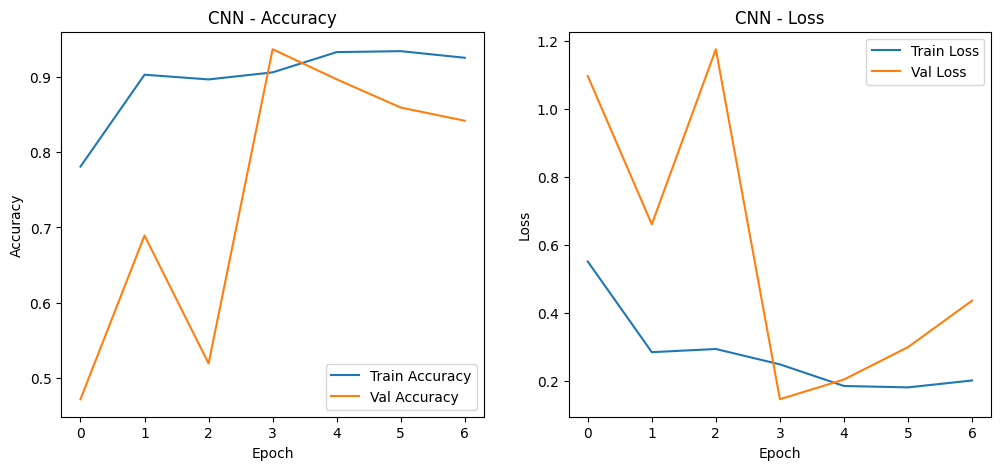

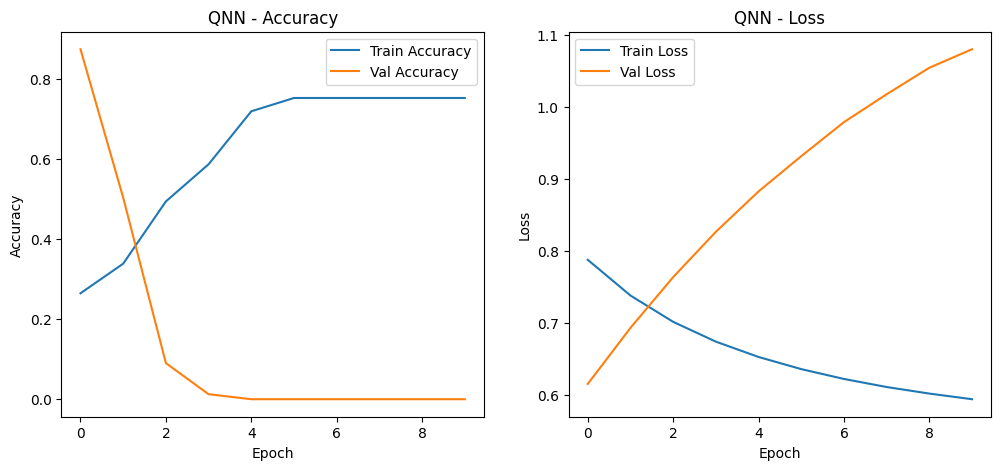

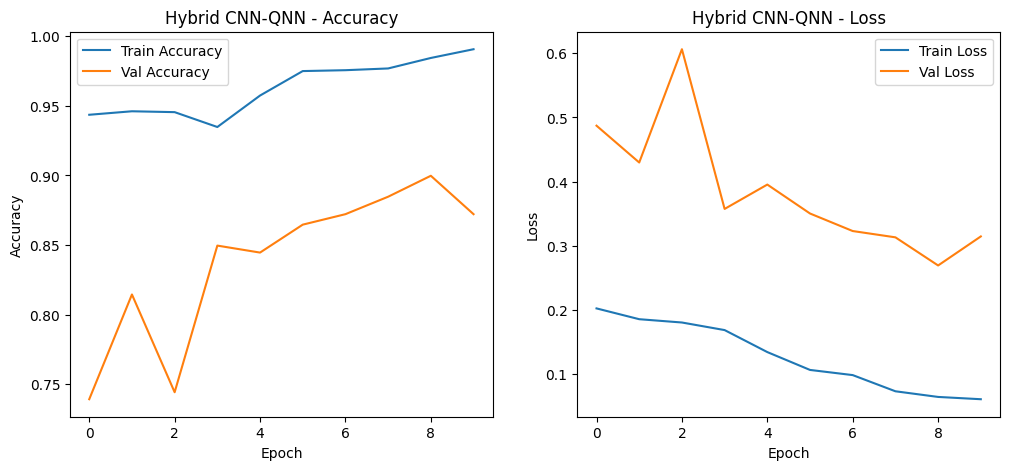

In [ ]:
#@title Evaluation and Visualization Functions

def plot_history(history, title="Model Accuracy and Loss"):
    # Plot Accuracy and Loss curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f"{title} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

# Plot training histories
plot_history(history_cnn, "CNN")
plot_history(history_qnn, "QNN")
plot_history(history_hybrid, "Hybrid CNN-QNN")


CNN Model Evaluation:
Test Loss: 0.1457, Test Accuracy: 0.9431
26/26 [==============================] - 14s 533ms/step
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       615
           1       0.91      0.85      0.88       194

    accuracy                           0.94       809
   macro avg       0.93      0.91      0.92       809
weighted avg       0.94      0.94      0.94       809



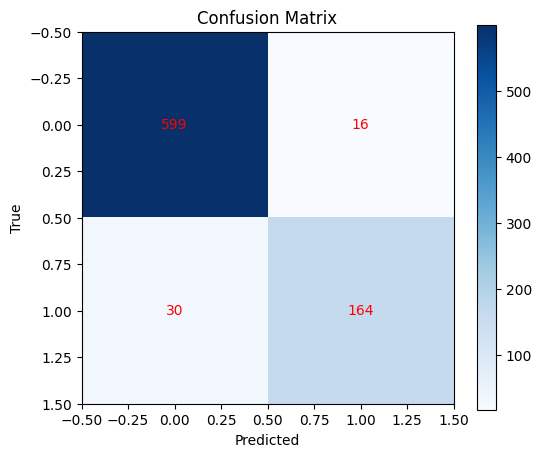

26/26 [==============================] - 9s 337ms/step


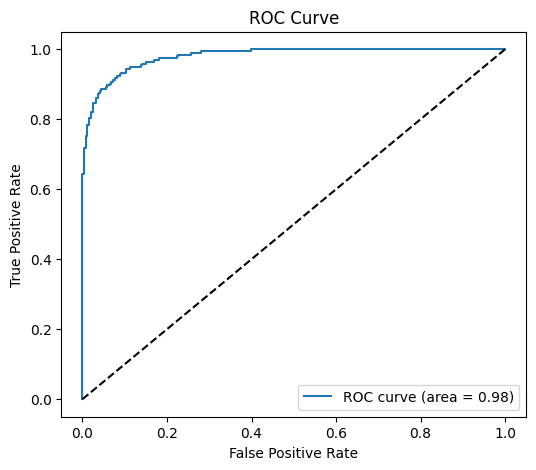

QNN Model Evaluation:
Test Loss: 0.5854, Test Accuracy: 0.7602
26/26 [==============================] - 1s 47ms/step
              precision    recall  f1-score   support

           0       0.76      1.00      0.86       615
           1       0.00      0.00      0.00       194

    accuracy                           0.76       809
   macro avg       0.38      0.50      0.43       809
weighted avg       0.58      0.76      0.66       809



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


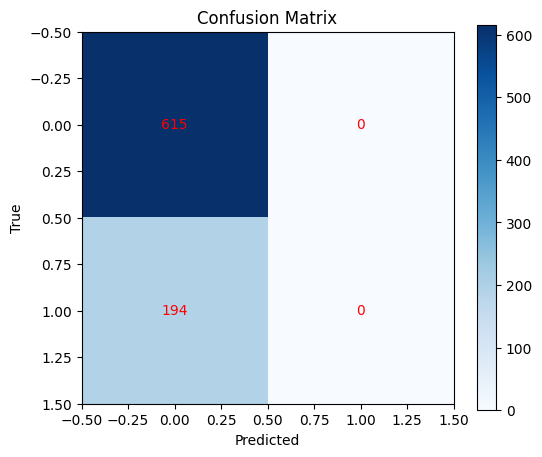

26/26 [==============================] - 1s 53ms/step


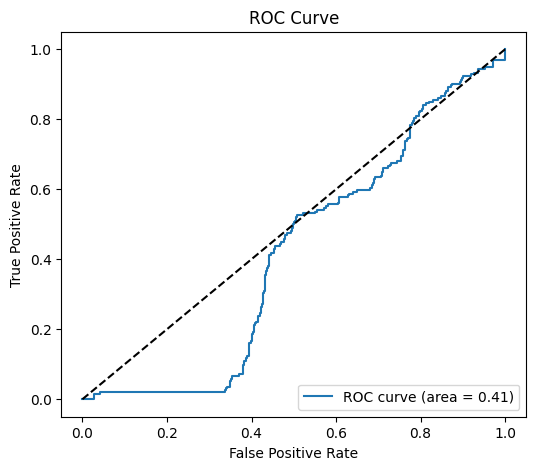

Hybrid Model Evaluation:
Test Loss: 0.0787, Test Accuracy: 0.9728
26/26 [==============================] - 13s 479ms/step
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       615
           1       0.99      0.89      0.94       194

    accuracy                           0.97       809
   macro avg       0.98      0.95      0.96       809
weighted avg       0.97      0.97      0.97       809



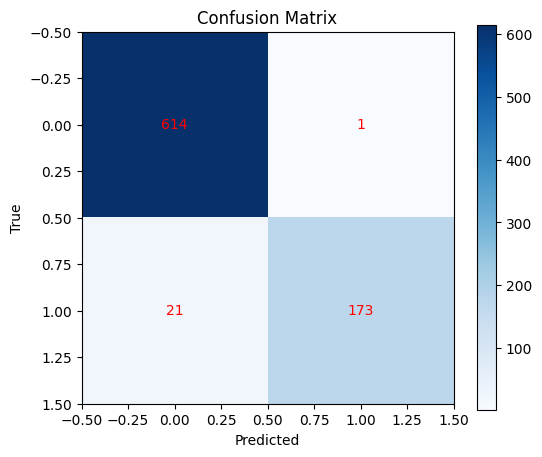

26/26 [==============================] - 12s 480ms/step


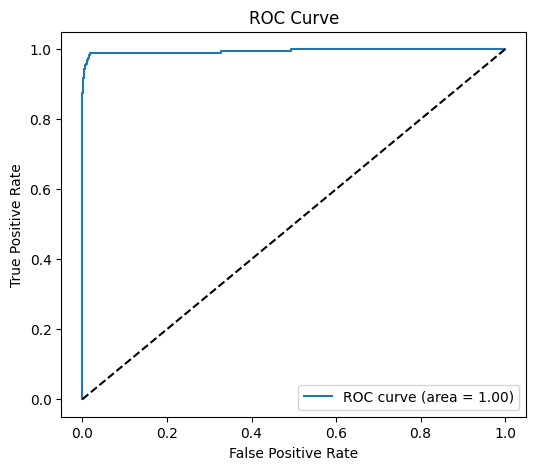

In [ ]:
def evaluate_model(model, X_test, y_test):
    results = model.evaluate(X_test, y_test, verbose=0)
    print("Test Loss: {:.4f}, Test Accuracy: {:.4f}".format(results[0], results[1]))
    y_pred = np.argmax(model.predict(X_test), axis=1)
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, cmap='Blues')
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.xlabel("Predicted")
    plt.ylabel("True")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center", color="red")
    plt.show()

    # ROC curve: compute probabilities for class 1 (weed)
    y_probs = model.predict(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

print("CNN Model Evaluation:")
evaluate_model(cnn_model, X_test, y_test)

print("QNN Model Evaluation:")
evaluate_model(qnn_model, X_test_reduced, y_test)

print("Hybrid Model Evaluation:")
evaluate_model(hybrid_model, X_test, y_test)


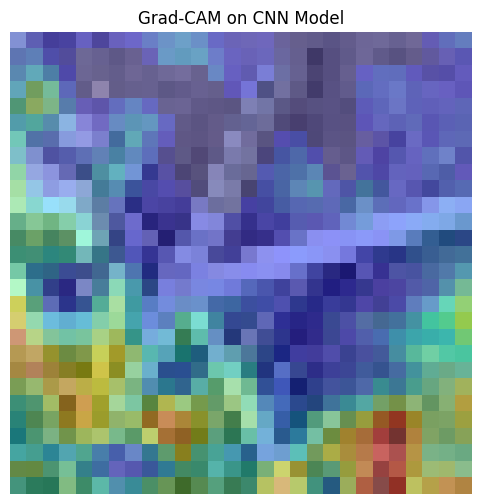

In [ ]:
#@title Grad-CAM for CNN Model

def get_gradcam_heatmap(model, image, last_conv_layer_name="conv2d_2"):
    # Expand dims for a single image
    img_tensor = np.expand_dims(image, axis=0)
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        predicted_class = tf.argmax(predictions[0])
        loss = predictions[:, predicted_class]
    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Visualize Grad-CAM on a sample image from test set using CNN model
sample_img = X_test[0]
heatmap = get_gradcam_heatmap(cnn_model, sample_img)
plt.figure(figsize=(6, 6))
plt.imshow(sample_img)
plt.imshow(heatmap, cmap='jet', alpha=0.4)
plt.title("Grad-CAM on CNN Model")
plt.axis('off')
plt.show()


In [ ]:
#@title Sample Prediction with Bounding Boxes on /content/dataset sample2.jpg

def detect_and_draw_boxes(model, image_path, threshold=0.5):
    # Load sample image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    orig = img_rgb.copy()

    # For demonstration, assume a sliding-window approach (dummy implementation)
    # Here, we split the image into 4 quadrants and classify each quadrant.
    h, w, _ = img_rgb.shape
    boxes = []
    # Define quadrants manually (this is a simplification)
    quadrants = [
        (0, 0, w//2, h//2),
        (w//2, 0, w, h//2),
        (0, h//2, w//2, h),
        (w//2, h//2, w, h)
    ]
    for (x1, y1, x2, y2) in quadrants:
        crop = cv2.resize(img_rgb[y1:y2, x1:x2], (128,128))/255.
        crop = np.expand_dims(crop, axis=0)
        pred = model.predict(crop)
        label = np.argmax(pred, axis=1)[0]
        # Assume: label 0 = corn (blue box), label 1 = weed (red box)
        color = (255,0,0) if label==1 else (0,0,255)
        boxes.append(((x1, y1, x2, y2), label))
        cv2.rectangle(orig, (x1, y1), (x2, y2), color, 2)
    plt.figure(figsize=(8,8))
    plt.imshow(orig)
    plt.title("Detected Regions: Blue = Corn, Red = Weed")
    plt.axis("off")
    plt.show()
    return boxes


In [ ]:
# Save the entire CNN model
cnn_model.save('cnn_model.keras')


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved CNN model
cnn_model = load_model('cnn_model.keras')


In [ ]:
# Save the QNN model weights
qnn_model.save_weights('qnn_model_weights.h5')


In [ ]:
# Save the QNN model architecture to JSON
qnn_json = qnn_model.to_json()
with open('qnn_model_architecture.json', 'w') as json_file:
    json_file.write(qnn_json)


In [ ]:
# Save the hybrid model weights
hybrid_model.save_weights('hybrid_model_weights.h5')


In [ ]:
# Save the hybrid model architecture to JSON
hybrid_json = hybrid_model.to_json()
with open('hybrid_model_architecture.json', 'w') as json_file:
    json_file.write(hybrid_json)


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_and_draw_boxes(model, image_path, threshold=0.5, window_size=(128, 128), step_size=64):
    """
    Detects objects in an image using a sliding window approach and draws bounding boxes.

    Parameters:
    - model: Trained detection model.
    - image_path: Path to the input image.
    - threshold: Confidence threshold for detections.
    - window_size: Size of the sliding window (width, height).
    - step_size: Step size for the sliding window.

    Returns:
    - orig: Image with detected bounding boxes drawn.
    - boxes: List of bounding boxes and their associated labels.
    """
    # Load and convert the image to RGB
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    orig = img_rgb.copy()
    h, w, _ = img_rgb.shape

    boxes = []

    # Sliding window over the image
    for y in range(0, h - window_size[1] + 1, step_size):
        for x in range(0, w - window_size[0] + 1, step_size):
            # Extract the window
            window = img_rgb[y:y + window_size[1], x:x + window_size[0]]
            # Resize window to model's input size
            resized_window = cv2.resize(window, window_size) / 255.0
            # Expand dimensions to match model's input
            input_data = np.expand_dims(resized_window, axis=0).astype('float32')
            # Predict using the model
            pred = model.predict(input_data)
            label = np.argmax(pred, axis=1)[0]
            confidence = np.max(pred)
            # If confidence exceeds the threshold, record the bounding box
            if confidence >= threshold:
                # Define color: Red for weed (label 1), Blue for corn (label 0)
                color = (255, 0, 0) if label == 1 else (0, 0, 255)
                # Draw rectangle on the original image
                cv2.rectangle(orig, (x, y), (x + window_size[0], y + window_size[1]), color, 2)
                # Append the box coordinates and label
                boxes.append(((x, y, x + window_size[0], y + window_size[1]), label))

    # Display the image with bounding boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(orig)
    plt.title("Detected Regions: Blue = Corn, Red = Weed")
    plt.axis("off")
    plt.show()

    return orig, boxes


1/1 [==============================] - 0s 85ms/step


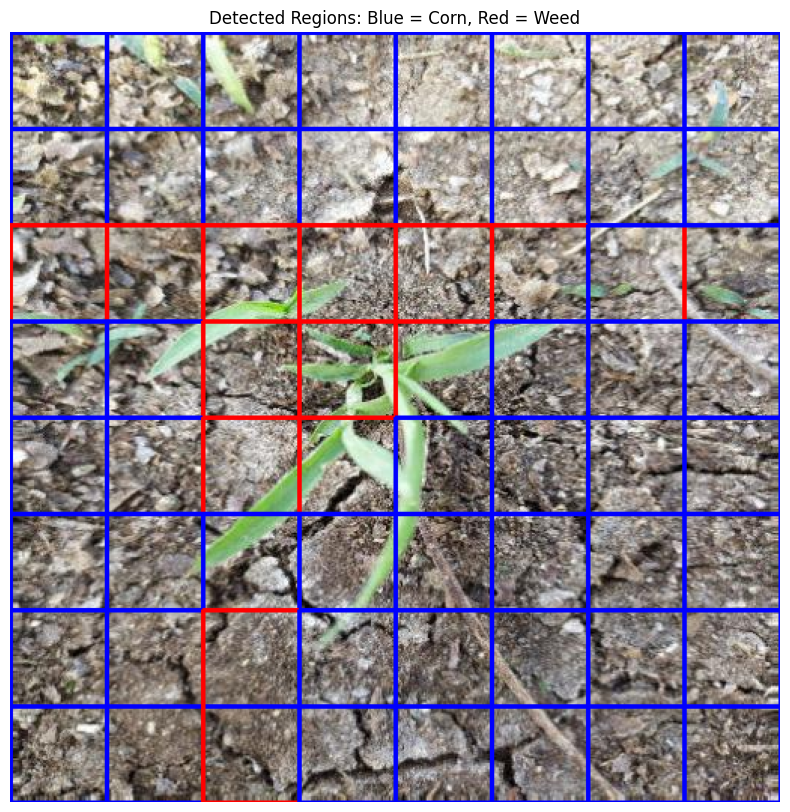

In [ ]:
# Assuming 'model' is your pre-trained detection model
image_path = '/content/weed.jpeg'
detected_image, detected_boxes = detect_and_draw_boxes(hybrid_model, image_path)


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_and_draw_boxes(model, image_path, threshold=0.5, window_size=(128, 128), step_size=64):
    """
    Detects objects in an image using a sliding window approach and draws bounding boxes with labels and confidence scores.

    Parameters:
    - model: Trained detection model.
    - image_path: Path to the input image.
    - threshold: Confidence threshold for detections.
    - window_size: Size of the sliding window (width, height).
    - step_size: Step size for the sliding window.

    Returns:
    - orig: Image with detected bounding boxes drawn.
    - boxes: List of bounding boxes and their associated labels and confidence scores.
    """
    # Load and convert the image to RGB
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    orig = img_rgb.copy()
    h, w, _ = img_rgb.shape

    boxes = []

    # Sliding window over the image
    for y in range(0, h - window_size[1] + 1, step_size):
        for x in range(0, w - window_size[0] + 1, step_size):
            # Extract the window
            window = img_rgb[y:y + window_size[1], x:x + window_size[0]]
            # Resize window to model's input size
            resized_window = cv2.resize(window, window_size) / 255.0
            # Expand dimensions to match model's input
            input_data = np.expand_dims(resized_window, axis=0).astype('float32')
            # Predict using the model
            pred = model.predict(input_data)
            label = np.argmax(pred, axis=1)[0]
            confidence = np.max(pred)
            # If confidence exceeds the threshold, record the bounding box
            if confidence >= threshold:
                # Define label and color
                if label == 1:
                    label_text = f'Weed: {confidence:.2f}'
                    color = (255, 0, 0)  # Red for weed
                else:
                    label_text = f'Corn: {confidence:.2f}'
                    color = (0, 0, 255)  # Blue for corn
                # Draw rectangle on the original image
                cv2.rectangle(orig, (x, y), (x + window_size[0], y + window_size[1]), color, 2)
                # Calculate text size for background rectangle
                (text_width, text_height), baseline = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
                # Draw filled rectangle for text background
                cv2.rectangle(orig, (x, y - text_height - baseline), (x + text_width, y), color, thickness=cv2.FILLED)
                # Put label text above the rectangle
                cv2.putText(orig, label_text, (x, y - baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
                # Append the box coordinates, label, and confidence
                boxes.append(((x, y, x + window_size[0], y + window_size[1]), label_text, confidence))

    # Display the image with bounding boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(orig)
    plt.title("Detected Regions: Blue = Corn, Red = Weed")
    plt.axis("off")
    plt.show()

    return orig, boxes


1/1 [==============================] - 0s 135ms/step


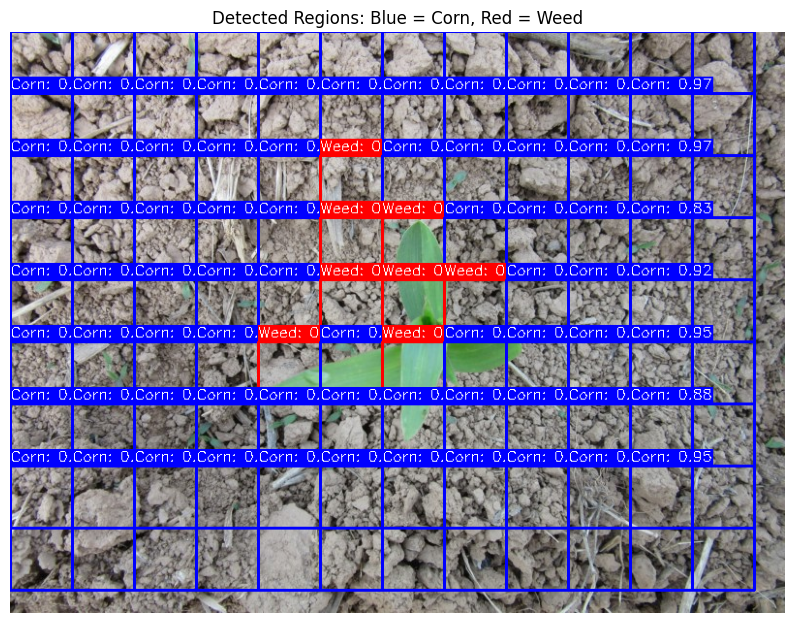

In [ ]:
# Assuming 'model' is your pre-trained detection model
image_path = '/content/corn.jpg'
detected_image, detected_boxes = detect_and_draw_boxes(hybrid_model, image_path)


<ipython-input-84-0370cf5ee830>:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-84-0370cf5ee830>:23: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




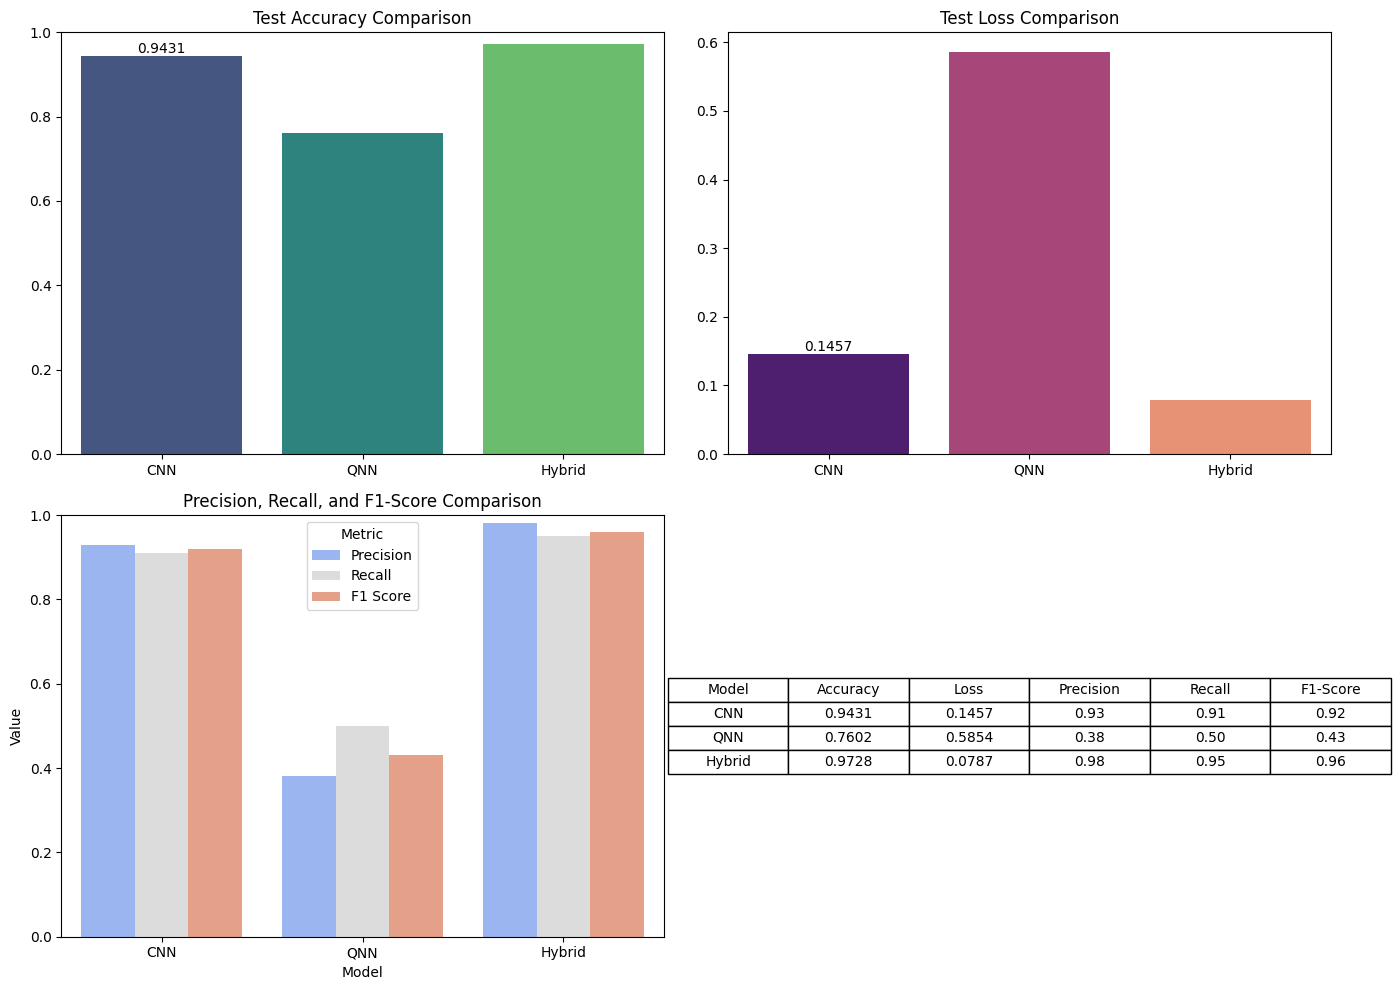

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def plot_dashboard():
    models = ['CNN', 'QNN', 'Hybrid']
    accuracy = [0.9431, 0.7602, 0.9728]
    loss = [0.1457, 0.5854, 0.0787]
    precision = [0.93, 0.38, 0.98]
    recall = [0.91, 0.50, 0.95]
    f1_score = [0.92, 0.43, 0.96]

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Accuracy Comparison
    sns.barplot(x=models, y=accuracy, ax=axes[0, 0], palette='viridis')
    axes[0, 0].set_title('Test Accuracy Comparison')
    axes[0, 0].set_ylim(0, 1)
    axes[0, 0].bar_label(axes[0, 0].containers[0], fmt='%.4f')

    # Loss Comparison
    sns.barplot(x=models, y=loss, ax=axes[0, 1], palette='magma')
    axes[0, 1].set_title('Test Loss Comparison')
    axes[0, 1].bar_label(axes[0, 1].containers[0], fmt='%.4f')

    # Precision, Recall, and F1 Score
    metrics_df = pd.DataFrame({
        'Model': models * 3,
        'Metric': ['Precision'] * 3 + ['Recall'] * 3 + ['F1 Score'] * 3,
        'Value': precision + recall + f1_score
    })

    sns.barplot(x='Model', y='Value', hue='Metric', data=metrics_df, ax=axes[1, 0], palette='coolwarm')
    axes[1, 0].set_title('Precision, Recall, and F1-Score Comparison')
    axes[1, 0].set_ylim(0, 1)

    # Summary Table
    cell_text = [
        ["CNN", "0.9431", "0.1457", "0.93", "0.91", "0.92"],
        ["QNN", "0.7602", "0.5854", "0.38", "0.50", "0.43"],
        ["Hybrid", "0.9728", "0.0787", "0.98", "0.95", "0.96"]
    ]
    columns = ["Model", "Accuracy", "Loss", "Precision", "Recall", "F1-Score"]
    axes[1, 1].axis('tight')
    axes[1, 1].axis('off')
    table = axes[1, 1].table(cellText=cell_text, colLabels=columns, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)

    plt.tight_layout()
    plt.show()

# Call the function to generate the dashboard
plot_dashboard()


In [ ]:
import dash
from dash import dcc, html
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import dash_bootstrap_components as dbc
from dash.dependencies import Input, Output

models = ["CNN", "QNN", "Hybrid"]
accuracy = [0.9431, 0.7602, 0.9728]  # Updated
precision = [0.93, 0.38, 0.98]  # Assuming Macro Average Precision
recall = [0.91, 0.50, 0.95]      # Assuming Macro Average Recall
f1_score = [0.92, 0.43, 0.96]  # Assuming Macro Average F1-Score
train_time = [50, 30, 40]

# Create Dash App
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

app.layout = dbc.Container([
    html.H1("Model Comparison Dashboard"),
    html.Hr(),

    # Dummy Input (hidden)
    html.Div(id='dummy-input', style={'display': 'none'}),

    # Graphs Section
    dbc.Row([
        dbc.Col(dcc.Graph(id='accuracy_graph'), width=6),
        dbc.Col(dcc.Graph(id='time_graph'), width=6)
    ]),
    dbc.Row([
        dbc.Col(dcc.Graph(id='precision_graph'), width=6),
        dbc.Col(dcc.Graph(id='f1_graph'), width=6)
    ]),
    dbc.Row([
        dbc.Col(dcc.Graph(id='scatter_graph'), width=6),  # Scatter plot
        dbc.Col(dcc.Graph(id='line_graph'), width=6)    # Line chart
    ]),
])
@app.callback(
    Output('accuracy_graph', 'figure'),
    Output('time_graph', 'figure'),
    Output('precision_graph', 'figure'),
    Output('f1_graph', 'figure'),
    Output('scatter_graph', 'figure'),  # Add scatter plot output
    Output('line_graph', 'figure'),    # Add line chart output

    Input('dummy-input', 'children')
)
def update_graphs(_):  # '_' indicates an unused input
    fig_acc = go.Figure([go.Bar(x=models, y=accuracy, marker_color=['blue', 'red', 'green'])])
    fig_acc.update_layout(title="Accuracy Comparison", yaxis_title="Accuracy", xaxis_title="Model")

    fig_time = go.Figure([go.Bar(x=models, y=train_time, marker_color=['blue', 'red', 'green'])])
    fig_time.update_layout(title="Training Time Comparison", yaxis_title="Time (s)", xaxis_title="Model")

    fig_prec = go.Figure([go.Bar(x=models, y=precision, marker_color=['blue', 'red', 'green'])])
    fig_prec.update_layout(title="Precision Comparison", yaxis_title="Precision", xaxis_title="Model")

    fig_f1 = go.Figure([go.Bar(x=models, y=f1_score, marker_color=['blue', 'red', 'green'])])
    fig_f1.update_layout(title="F1-Score Comparison", yaxis_title="F1 Score", xaxis_title="Model")


    # Scatter Plot
    fig_scatter = go.Figure(data=[go.Scatter(x=accuracy, y=precision, mode='markers',
                                             marker=dict(size=10, color='blue'))])
    fig_scatter.update_layout(title="Accuracy vs. Precision", xaxis_title="Accuracy", yaxis_title="Precision")

    # Line Chart
    fig_line = go.Figure(data=[go.Scatter(x=models, y=accuracy, mode='lines+markers',
                                          marker=dict(size=8, color='red'))])
    fig_line.update_layout(title="Accuracy Trend", xaxis_title="Model", yaxis_title="Accuracy")



    return fig_acc, fig_time, fig_prec, fig_f1, fig_scatter, fig_line


if __name__ == '__main__':
    app.run_server(debug=True)

<IPython.core.display.Javascript object>